# 4.4 Preconditioning

In [1]:
using Gadfly
using PyPlot:spy

## A. Introduction to Preconditioning

Suppose we want to solve the linear system
\begin{equation}
Kz=r
\end{equation}
for the unknown $z$. 

An estimate for the worst-case loss of precision when solving this linear system is given by the *condition number*

\begin{equation}
\text{cond}(K)=\|K\|\|K^{-1}\|
\end{equation}

One should think of the condition number as being (roughly) the rate at which the solution, $z$, will change with respect to a change in $r$. If the condition number is large, even a small relative error in the right-hand side $r$ may cause a large relative error in the computed $z$, and the problem is said to be *ill-conditioned*. On the other hand, if the condition number is small, the relative error in $z$ will not be much bigger than the relative error in $r$.

Although the condition number depends on the norm used in the definition, if the matrix is *well-conditioned*, the condition number will be small in all norms, and if the matrix is ill-conditioned, the condition number will be large in all norms.

The condition number of the matrix is important, because it influences the convergence rate of iterative methods to solve the linear system.

For example, consider the Vandermonde matrix $K$, defined as

In [2]:
n = 7
K = [i^(j-1) for i=1:n, j=1:n]

7×7 Array{Int64,2}:
 1  1   1    1     1      1       1
 1  2   4    8    16     32      64
 1  3   9   27    81    243     729
 1  4  16   64   256   1024    4096
 1  5  25  125   625   3125   15625
 1  6  36  216  1296   7776   46656
 1  7  49  343  2401  16807  117649

This matrix has a notoriously high condition number:

In [3]:
cond(K)

2.445909787124096e7

As a rule of thumb, if the condition number of a matrix is $O(10^p)$, you may loose up to $p$ digits of accuracy when solving for $z$!

For normal matrices, we have the equivalent definition
\begin{equation}
\text{cond}(K)=\frac{\lambda_\text{max}}{\lambda_\text{min}}
\end{equation}
with $\lambda_\text{max}$ and $\lambda_\text{min}$ the maximal and minimal eigenvalue of $K$.

In [4]:
D,V = eig(K)
maximum(D)/minimum(D)

1.755985631471913e7

In fact, it is known that the convergence rate of iterative methods for solving $Kz=r$ depends not only on the ratio between largest and smallest eigenvalue, but on the complete *spectrum* of the matrix, that is, its set of eigenvalues. For examples, if the spectrum contains a number of well-defined clusters, iterative methods will converge fast. 

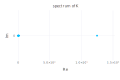

In [5]:
p = plot(
    x=real(D),
    y=imag(D),
    Geom.point,
    Guide.xlabel("Re"),
    Guide.ylabel("Im"),
    Guide.title("spectrum of K"),
    Theme(highlight_width = 0pt)
)
draw(SVG(12cm, 8cm),p)

A *preconditioner* $P$ of a matrix $K$ is a matrix such that $P^{-1}K$ has a smaller condition number then $K$.

Hence, instead of $Kz=r$, a *preconditioned system*
\begin{equation}
P^{-1}Kz=P^{-1}r
\end{equation}
is solved.

The condition number for this system system is reduced by squeezing the eigenvalues of the preconditioned matrix into a small number of tight clusters. When using iterative methods, such as GMRES or SYMMLQ, for solving the preconditioned system, convergence is typically reached after only a few iterations.

Consider these two trivial choices for $P$:

- **choice 1**: $P=K$. In this case, we have $P^{-1}K=K^{-1}K=I$, thus $\text{cond}(P^{-1}K)=1$. However, this requires that we compute $K^{-1}$ explicitly, which is usually more difficult than solving the linear system.

- **choice 2**: $P=I$. In this case, we have $P^{-1}K=IK=K$, thus $\text{cond}(P^{-1}K)=\text{cond}(K)$. Now, the inverse $I^{-1}$ is cheap, but the condition number is not reduced.

The goal is now to find a matrix $P$ such that $\text{cond}(P^{-1}K)\approx1$ **and** such that the application of the preconditioner $P^{-1}$ is cheap. 

## B. Preconditioning for PDE constrained optimization

A generic problem class in PDE constrained optimization are linear-quadratic or QP problems. They are known to have a large spectrum!

A QP is a quadratic optimization problem with linear constraints

\begin{align}
\underset{u,y}{\text{min}}\frac{1}{2}\left(y^\top H_{yy} y + y^\top H_{yu} u + u^\top H_{uy} y + u^\top H_{uu} u \right) + f_y^\top y + f_u^\top u, \\
C_y y + C_u u + c = 0,
\end{align}

where $y\in\mathbb{R}^{n_y}$ is the state vector, and $u\in\mathbb{R}^{n_u}$ are the inputs. The vectors $c,f_y\in\mathbb{R}^{n_y}$, $f_u\in\mathbb{R}^{n_u}$ and all other variables are vectors or matrices of the appropriate size.

It is known that the QP has a KKT system of the form

\begin{equation}
\begin{pmatrix}
H_{yy} & H_{yu} & C_y^\top \\
H_{uy} & H_{uu} & C_u^\top \\
C_y & C_u & 0
\end{pmatrix}
\begin{pmatrix}
y\\
u\\
p
\end{pmatrix} =
-\begin{pmatrix}
f_y\\
f_u\\
c
\end{pmatrix},
\end{equation}

which we will denote in short by

\begin{equation}
Kz=r.
\end{equation}

The matrix $K$ is symmetric and has a clear block structure. This has motivated research in block-structured preconditioners that preserve the symmetry structure. In literature, the following form for the precontioner has been proposed:

\begin{equation}
P = 
\begin{pmatrix}
0 & 0 & A^\top \\
0 & B & C_u^\top \\
A & C_u & 0
\end{pmatrix},
\end{equation}

where $A$ should be an approximation for the forward system matrix $C_y$, and $B$ is an approximation to the reduced Hessian

\begin{equation}
S=H_{uu}-H_{uy}C_y^{-1}C_u-C_u^\top C_y^{-\top} H_{yu}+C_u^\top C_y^{-\top}H_{yy}C_y^{-1}C_u.
\end{equation}

Note that the reduced Hessian is the Schur-complement of the KKT matrix with respect to the variables $y$ and $p$.

Results from literature suggest that in fact, $B$ should be an approximation to the approximate reduced Hessian

\begin{equation}
S_A=H_{uu}-H_{uy}A^{-1}C_u-C_u^\top A^{-\top} H_{yu}+C_u^\top A^{-\top}H_{yy}A^{-1}C_u,
\end{equation}

where the forward system matrix $C_y$ is replaced by its approximation $A$.

The inverse of the preconditioner $P$ can be computed as
\begin{equation}
P^{-1} = 
\begin{pmatrix}
A^{-1}C_u B^{-1}C_u^\top A^{-\top} & -A^{-1}C_u B^{-1} & A^{-1} \\
-B^{-1}C_u^{\top}A^{-\top} & B^{-1} & 0 \\
A^{-\top} & 0 & 0
\end{pmatrix},
\end{equation}

Hence, we only need to know the matrices $A^{-1}$ and $B^{-1}$.

The approximation for the inverse of $C_y \approx A$ can be computed by (for example) Jacobi iteration steps. We assumes that the forward system matrix is diagonally dominant. Split the system matrix $C_y$ in $C_y = D + R$ where $D = \text{diag}(C_y)$. We find the following approximation for $A^{-1}$:

\begin{align}
A_0^{-1} &= D^{-1} \\
A^{-1}_i &= D^{-1}(I-RA_{i-1}^{-1}) \quad \text{ for } i>0.
\end{align}

In [6]:
function Jacobi(Cy, n)
    n >= 0 || error("n must be non-negative")
    R = Cy - spdiagm(diag(Cy))
    Dinv = spdiagm(1./diag(Cy))
    Jacobi_step(Dinv, R, n) # subroutine
end

function Jacobi_step(Dinv, R, n)
    n == 0 && return Dinv
    Dinv*(eye(R)-R*Jacobi_step(Dinv,R,n-1)) # recurse
end

Jacobi_step (generic function with 1 method)

Similarly, we choose $B_0=H_{uu}$ and $B_j$ as the approximation to $S_A$ after $j$ Richardson iterations:

\begin{align}
B_0^{-1} &= H_{uu}^{-1} \\
B^{-1}_j &= H_{uu}^{-1}(I-(C_u^\top A_i^{-\top} H_{yy} A_i^{-1} C_u)B_{j-1}^{-1}) \quad \text{ for } j>0.
\end{align}

In [7]:
function Richardson(Huu, Hyy, Cu, Aiinv, n)
    n >= 0 || error("n must be non-negative")
    Huuinv = spdiagm(1./diag(Huu))
    M = Cu'*Aiinv'*Hyy*Aiinv*Cu
    Richardson_step(Huuinv, M, n) # subroutine
end

function Richardson_step(Huuinv, M, n)
    n == 0 && return Huuinv
    Huuinv*(eye(M)-M*Richardson_step(Huuinv,M,n-1)) # recurse
end 

Richardson_step (generic function with 1 method)

## C. Example

We discuss preconditioning for PDE constrained optimization using the example on page 56.

Consider the basic elliptic control problem

\begin{align}
\text{min}\frac{1}{2}\int_0^1 (y(x)-\bar{y}(x))^2 \text{d}x + \frac{\nu}{2} \int_0^1 u(x)^2 \text{d}x, \\
-y''(x) = u(x) \quad \forall x \in [0,1], \\
y(0) = y(1) = 0,
\end{align}

with the state $y$ and inputs $u$ functions defined on the domain $[0,1]$.

Discretizing the elliptic problem, we obtain a discrete laplacian for the forward system matrix

\begin{equation}
C_y
=
\frac{1}{h^2}
\begin{pmatrix}
-2 & 1 & & & \\
1 & -2 & 1 & & \\
& \ddots & \ddots & \ddots & \\
& & 1 & -2 & 1 \\
& & & 1 & -2 \\
\end{pmatrix}.
\end{equation}

In [8]:
laplacian(N) = begin
    h = 1/(N-1)
    d₁ = -2*ones(N-1)
    d₂ = ones(N-2)
    A = 1/h^2*spdiagm((d₂,d₁,d₂),(-1,0,1))    
end

laplacian (generic function with 1 method)

Suppose we discretize the domain in 100 subintervala of length 1/100, and choose the regularization parameter $\nu=0.001$.

In [9]:
N = 101
h = 1/(N-1)
x = h:h:1
ν = 0.001;

The target function $\bar{y}$ is defined as

\begin{equation}
\bar{y}(x)
=
\begin{cases}
0.8-x \quad &0 \leq x \leq 0.4 \\
-2.6+2x \quad &0.4 < x \leq 1
\end{cases}.
\end{equation}

In [10]:
ybar(x::Number) = x <= 0.4 ? 0.8 - x : -2.6 + 2*x

ybar (generic function with 1 method)

The fully discretized problem is a QP with

\begin{equation}
H_{yy}=hI, \quad H_{yu}=H_{uy}^\top=0, \quad H_{uu}=\nu h I, \quad C_u=I, \quad f_y=-h\bar{y}, \quad f_u=0, \quad c=0,
\end{equation}

and $I \in \mathbb{R}^{N-1}$.

In [11]:
Hyy = h*speye(N-1)
Hyu = Huy = spzeros(N-1,N-1)
Huu = ν*h*speye(N-1)
Cu = speye(N-1)
fy = -h*ybar.(x) # syntactic loop fusion
fu = 0*x
c = 0*x
Cy = laplacian(N);

The KKT matrix $K$ is thus

In [12]:
K = [Hyy Hyu Cy'; Huy Huu Cu'; Cy Cu spzeros(N-1,N-1)];

It is a sparse matrix with a clear block structure. Let's look at a *spy*-plot:

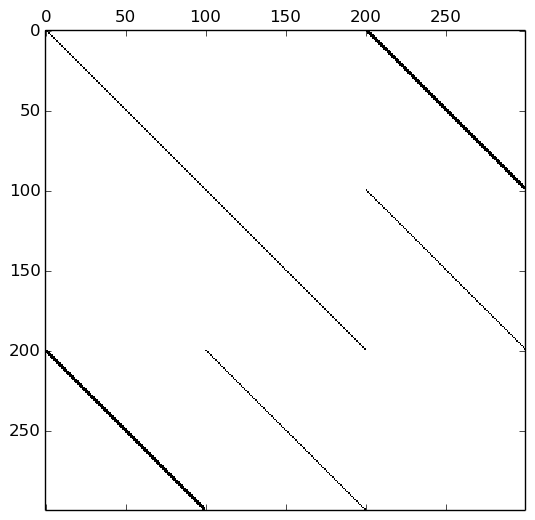

PyObject <matplotlib.image.AxesImage object at 0x7f68bfd9eb90>

In [13]:
PyPlot.spy(K)

The right-hand side $r$ is defined as

In [14]:
r = -vcat(fy,fu,c);

and use the standard backslash solver to compute a solution

In [15]:
z = K\r
y = z[1:N-1]
u = z[N:2*N-2]
target = ybar.(x);

and make a plot of the target and state:

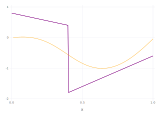

In [16]:
l1 = layer(
    x=x,
    y=y,
    Geom.line,
    Theme(default_color=colorant"orange")
)

l2 = layer(
    ybar,
    0,
    1,
    Geom.line,
Theme(default_color=colorant"purple")
)

p = plot(
    l1,
    l2,
    Guide.xlabel("x"),
    Guide.ylabel("")
)

draw(SVG(16cm, 12cm),p)

Now, let's precondition the matrix with the preconditioner $P$ as described above. We define the inverse of the preconditioner, based on the approximation for the inverse of the forward system matrix $A^{-1}$ and the approximation for the inverse of the reduced hessian $B^{-1}$.

In [17]:
inverse_P(Ainv, Binv, C) = begin
    n = size(Ainv,1)
    Pinv = spzeros(3*n,3*n)
    Pinv[1:n,1:n] = Ainv*C*Binv*C'*Ainv'
    Pinv[1:n,n+1:2*n] = -Ainv*C*Binv
    Pinv[1:n,2*n+1:3*n] = Ainv
    Pinv[n+1:2*n,1:n] = -Binv*C'*Ainv'
    Pinv[n+1:2*n,n+1:2*n] = Binv
    Pinv[2*n+1:3*n,1:n] = Ainv'
    
    return Pinv
end

# definition of (approximate) reduced Schur factor for later use
inverse_S(Huu,Cu,Cyinv,Hyy) = inv(full(Huu+Cu'*Cyinv'*Hyy*Cyinv*Cu))

inverse_S (generic function with 1 method)

We pick the values

In [18]:
i = 5
j = 1;

and compute the matrices $A^{-1}_i$ and $B^{-1}_j$ as

In [19]:
Aiinv = Jacobi(Cy, i)
Bjinv = Richardson(Huu, Hyy, Cu, Aiinv, j);

Using these matrices, we compute the inverse of the preconditioner

In [20]:
Pinv = inverse_P(Aiinv,Bjinv,Cu);

Next, we compare the spectrum of the original KKT matrix $K$ with that of the preconditioned sytem matrix 

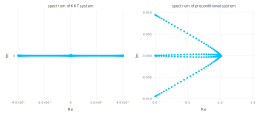

In [21]:
D,V = eig(full(K))
D_prec,V_prec = eig(full(Pinv*K))

p1 = plot(
    x=real(D),
    y=imag(D),
    Geom.point,
    Guide.xlabel("Re"),
    Guide.ylabel("Im"),
    Guide.title("spectrum of KKT system"),
    Theme(highlight_width = 0pt)
)

p2 = plot(
    x=real(D_prec),
    y=imag(D_prec),
    Geom.point,
    Guide.xlabel("Re"),
    Guide.ylabel("Im"),
    Guide.title("spectrum of preconditioned system"),
    Theme(highlight_width = 0pt)
)

draw(SVG(26cm, 12cm),hstack(p1,p2))

The eigenvalues of the preconditioned system lay indeed much more clusterd, hence, we expect iterative methods such as GMRES to perform better. An implementation of GMRES is provided in the "IterativeSolvers" package.

In [22]:
#Pkg.add("IterativeSolvers")
using IterativeSolvers

Let us now reproduce the the table on page 58. We store the number of iterations in the $\texttt{iters}$ variable. 

In [23]:
is = [0 10 20 100 1000] # number of iterations for A
ni = length(is)
js = [0 1 "S_A" "S"] # number of iterations for B
nj = length(js)
ks = [length(r) 30] # choice of GMRES method (size(K,1) -> infinity)
nk = length(ks)
iters = zeros(Int64,ni,nj,nk);

In [24]:
# compute for the non-preconditioned system
iters0 = zeros(Int64,nk);
for k in 1:nk
    (x, h) = gmres(K,r,restart=ks[k],tol=1e-6,maxiter=length(r))
    iters0[k] = ks[k] == length(r) ? sum(h.residuals.>eps()) : div(sum(h.residuals.>eps()),ks[k]) + 1
end

In [25]:
# let's loop!
for i in 1:ni
    for j in 1:nj
        for k in 1:nk
            Aiinv = Jacobi(Cy, is[i]) # compute approx of system matrix
            Bjinv = js[j] == "S" ? inverse_S(Huu,Cu,inv(full(Cy)),Hyy) : 
            js[j] == "S_A" ? inverse_S(Huu,Cu,Aiinv,Hyy) : Richardson(Huu, Hyy, Cu, Aiinv, js[j]) # compute approx of hessian
            Pinv = inverse_P(Aiinv,Bjinv,Cu) # compute inverse of the preconditioner
            K_ = Pinv*K # preconditoned system
            r_ = Pinv*r
            (x, h) = gmres(K_,r_,restart=ks[k],tol=1e-6,maxiter=length(r))
            iters[i,j,k] = ks[k] == length(r) ? sum(h.residuals.>eps()) : div(sum(h.residuals.>eps()),ks[k]) + 1
        end
    end
end

In [26]:
# plot table
header = "|   i     |   j     |"
for k in 1:nk
    header *= (("  GMRES($(ks[k]))")*repeat(" ",20))[1:14]*"|"
end
header *= "\n"

hline = repeat("-",length(header)-1)*"\n"

header *= repeat("|"*repeat(" ",9),2)
for k in 1:nk
    header *= ks[k] == length(r) ? ("| # inner it.  ") : ("| # outer it.  ")
end
header *= "|\n"

content = ""
content *= ("|   -"*repeat(" ",9))[1:10]
content *= ("|   -"*repeat(" ",9))[1:10]
for k = 1:nk
    content *= ("|     $(iters0[k]<length(r)?iters0[k]:"-")"*repeat(" ",20))[1:15]
end
content *= "|\n"
content *= hline
for i = 1:ni
    for j = 1:nj
        content *= ("|   $(is[i])"*repeat(" ",9))[1:10]
        content *= ("|   $(js[j])"*repeat(" ",9))[1:10]
        for k = 1:nk
            content *= ("|     $(iters[i,j,k]<length(r)?iters[i,j,k]:"-")"*repeat(" ",20))[1:15]
        end
        content *= "|\n"
    end
    content *= hline
end

@printf("%s",hline)
@printf("%s",header)
@printf("%s",hline)
@printf("%s",content)

---------------------------------------------------
|   i     |   j     |  GMRES(300)  |  GMRES(30)   |
|         |         | # inner it.  | # outer it.  |
---------------------------------------------------
|   -     |   -     |     204      |     -        |
---------------------------------------------------
|   0     |   0     |     185      |     -        |
|   0     |   1     |     185      |     -        |
|   0     |   S_A   |     185      |     -        |
|   0     |   S     |     186      |     -        |
---------------------------------------------------
|   10    |   0     |     57       |     6        |
|   10    |   1     |     57       |     6        |
|   10    |   S_A   |     57       |     6        |
|   10    |   S     |     58       |     7        |
---------------------------------------------------
|   20    |   0     |     41       |     3        |
|   20    |   1     |     41       |     3        |
|   20    |   S_A   |     41       |     3        |
|   20    | 

## D. Assignments

- Play around with the regularization parameter $\nu$. What is the effect on the spectrum of the preconditioned matrix? On the number of GMRES iterations?
- Increase the number of points in the discretization. What do you observe?
- Make the table above with some other values for $i$ and $j$. Why does the choice of $j$ not influence the number of iterations for this problem? 